In [21]:
import numpy as np
import matplotlib.pyplot as plt


def f(x):
    #return #np.exp(-np.sin(2*x)**2) + np.exp(-np.cos(5*x)**2)
    return np.sin(10*x)/(5*x)

def fourier_f(x):
    return np.exp(-x**2/4)

### Implementera i MPI ###########
def dot(a, b):
    return matmat(adjoint(a), b)                # MPI: Recursive doubling

def adjoint(A):
    return A.conj().T

def matmat(A, B):
    return A @ B                                # MPI: transpose after

def outer(a, b):
    return np.outer(a, b)

def add_mult(a, b, c):
    return a + c*b
##################################

def conjgrad(x0, A, b, M=None):
    Ax0 = matmat(A, x0)                         # MPI: transpose Ax0 after matmat
    r = add_mult(b, Ax0, -1)                    # MPI: rank wise     
    p = r
    if M is None:
        M = len(b) - 1
    for m in range(M):
        Ap = matmat(A, p)                       # MPI: transpose Ap after matmat
        a = dot(r, r) / dot(p, Ap)              # MPI: recursive doubling for dot
        x0 = add_mult(x0, p, a)                 # MPI: rank wise
        r_new = add_mult(r, Ap, -a)             # MPI: rank wise
        b = dot(r_new, r_new) / dot(r, r)       # MPI: recursive doubling for dot
        r = r_new                               # MPI: rank wise
        p = add_mult(r, p, b)                   # MPI: rank wise
    return x0
    
def solve(x, fx, w, b0, regul=0.00, **kwargs):
    E = np.exp(outer(x, w)*1j)
    Ea = adjoint(E)
    A = matmat(Ea, E) + regul*np.diag((1+np.abs(w)))
    b = matmat(Ea, fx)
    return conjgrad(b0, A, b, **kwargs)


def step_mh(x, w, fx, beta, sigma, gamma, **kwargs):
    # Propoal
    K = len(w)
    noise = np.random.randn(K)
    w_new = add_mult(w, noise, sigma)
    beta_new = solve(x, fx, w_new, beta, **kwargs)
    
    # Slumpsteget
    alpha = np.random.uniform(0, 1, len(beta_new))
    proba = np.abs(beta_new / beta)**gamma
    
    # New state
    w_new = np.where(alpha < proba, w_new, w)
    beta_new = solve(x, fx, w_new, beta, **kwargs)
    
    print(f"fraction accepted: {np.sum(alpha < proba)/len(alpha):.2f}", end="\r")
    return w_new, beta_new

def eval(x, w, beta):
    return np.real(np.exp(outer(x, w)*1j) @ beta)

def mh(x,fx, sigma, gamma, num_it, K, **kwargs):
    w = np.random.randn(K)
    beta = solve(x, fx, w, np.zeros(K), **kwargs)
    for m in range(num_it):
        w, beta = step_mh(x, w, fx, beta, sigma, gamma, **kwargs)
    return w, beta

def mh_split(x, fx, sigma, gamma, K, num_it, num_split, **kwargs):
    w = np.random.randn(K)
    w_list = np.array_split(w, num_split)
    x_list = np.array_split(x, num_split)
    fx_list = np.array_split(fx, num_split)
    
    for i in range(num_split):
        print(f"Split {i+1}/{num_split}", end="\r")
        Ki = len(w_list[i])
        beta = solve(x_list[i], fx_list[i], w_list[i], np.zeros(Ki))
        for m in range(num_it):
            w_list[i], beta = step_mh(x_list[i], w_list[i], fx_list[i], beta, sigma, gamma)
    w = np.concatenate(w_list)
    beta = solve(x, fx, w, np.zeros(K), **kwargs)
    return w, beta




# Generate data
K = 100
N = 1000

# Points, function values: (x, fx) 
x = np.random.uniform(-3, 3, N)
fx = f(x) + 0.1*np.random.randn(N)

# Weights, Coefficients: (w, beta)
w_0 = 2*np.random.randn(K)
beta_0 = solve(x, fx, w_0, np.zeros(K), M=K-1)

# Run Metropolis-Hastings!
gamma = 10
w_1, beta_1 = mh(x, fx, sigma=1., gamma=gamma, K=K, num_it=3000, M=K-1)
w_2, beta_2 = mh_split(x, fx, sigma=1., gamma=gamma, K=K, num_it=3000, num_split=4, M=K-1)
w_3, beta_3 = mh(x, fx, sigma=1, gamma=gamma, K=K//4, num_it=3000, M=K//4-2)

#vilmer.strom@gmail.com

Error MH: 0.46494266608555584
Error Split MH: 1.0449001767502608


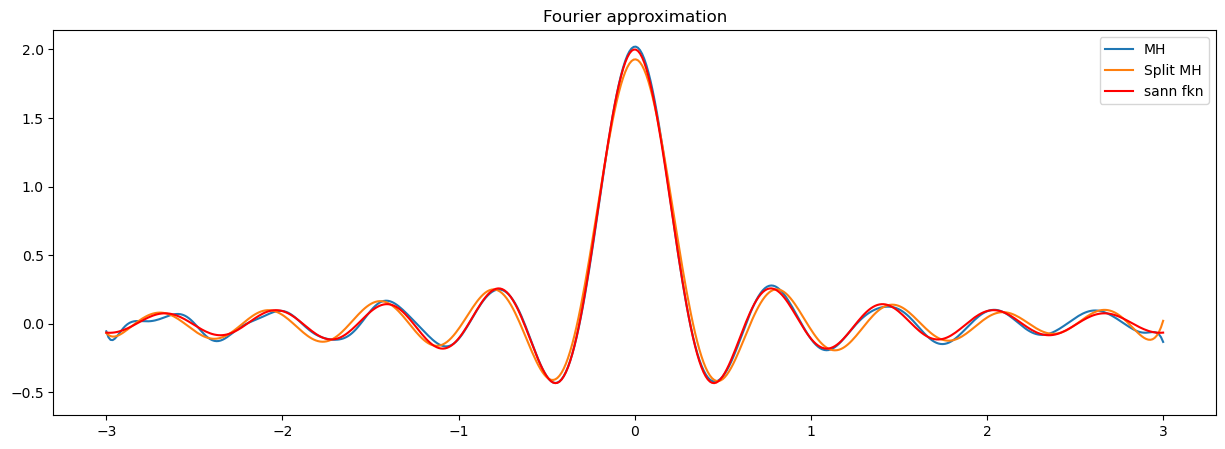

In [22]:
w_list = [w_0, w_1, w_2, w_3]
beta_list = [beta_0, beta_1, beta_2, beta_3]
labels = ["Initial", "MH", "Split MH", "MH (K=K/4)"]

x_eval = np.linspace(-3, 3, 500)
f_evals = []

plt.figure(figsize=(15, 5))
plt.title("Fourier approximation")
for w, beta, label in zip(w_list, beta_list, labels):
    if label in ["MH", "Split MH"]:
        f_evals.append(eval(x_eval, w, beta))
        plt.plot(x_eval, f_evals[-1].real, label=label)
        print(f"Error {label}: {np.linalg.norm(f(x_eval) - f_evals[-1])}")
plt.plot(x_eval, f(x_eval), 'r-', label="sann fkn")
#plt.scatter(x, fx, color='red', label="data", s=6, alpha=0.5)
plt.ylim(min(fx), max(fx))
plt.legend()
